__authors__: Bruno Limon, Carlo Volpe, Chiara Menchetti, Davide Di Virgilio

___

## Classification

Preparing data and imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, PrecisionRecallDisplay, plot_precision_recall_curve

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
data = pd.read_csv('df_without_duplicates.csv') 
data.head(5)

,content,fake
0,what we can learn from the resurgence of covid...,0
1,why approving a covid 19 vaccine too early cou...,0
2,not sure you have covid 19 here are the sympto...,0
3,flu study highlights difficulty of achieving c...,0
4,resign or return the dilemma facing classroom ...,0


Data preprocessing

Applying word embedding with the help of SKlearn's fucntion 'TFidfVectorizer', which turns a collection a documents, in this case, news articles, into a sparse matrix containing the vectors that represent the words in the document and their context and meaning

In [45]:
X = data['content']
y = data['fake']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=0)

TFvectorizer = TfidfVectorizer(stop_words='english',
                               ngram_range=(1,2),
                               max_df=.8,
                               min_df=.0001
                               )

X_train = TFvectorizer.fit_transform(X_train)
X_test = TFvectorizer.transform(X_test)

# # In case CountVectorizer is preferred
# Cntvectorizer = CountVectorizer(stop_words='english',
#                                 ngram_range=(1,2),
#                                 max_df=.8)

# X_train = Cntvectorizer.fit_transform(X_train)
# X_test = Cntvectorizer.transform(X_test)

# Looking at the distribution of labels in the target variable, as well as info on the X_train matrix
print(np.unique(y_train, return_counts=True))
X_train

(array([0, 1]), array([45046,  1630]))


<46676x25263 sparse matrix of type '<class 'numpy.float64'>'
	with 881245 stored elements in Compressed Sparse Row format>

Quick-testing a model, to check if the vectorizing phase went well and a classifying model is able to correctly detect fake news. For this, a simple model with the default parameters is used.

Aditionally, a classification report is produced together with a confusion matrix, a ROC curve and a Precision-Recall curve to further analyze the performance of the classifying task.

0.9818045488627843
              precision    recall  f1-score   support

           0     0.9816    0.9999    0.9907     19307
           1     0.9941    0.4814    0.6486       698

    accuracy                         0.9818     20005
   macro avg     0.9878    0.7406    0.8197     20005
weighted avg     0.9820    0.9818    0.9787     20005



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


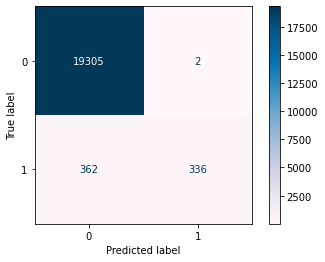

In [47]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits = 4))
plot_confusion_matrix(clf, X_test, y_test, cmap='PuBu')

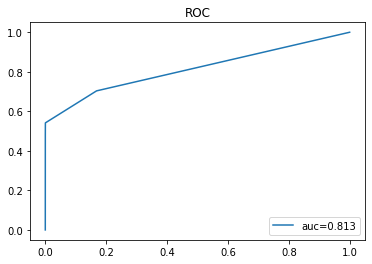

In [48]:
# y_pred_proba = clf._predict_proba_lr(X_test)[::,1]
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.title('ROC')
plt.show()

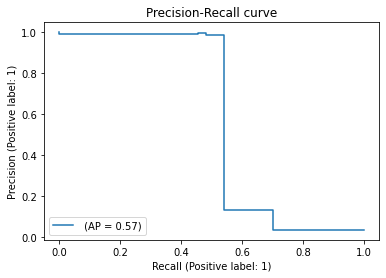

In [49]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, name="")
_ = display.ax_.set_title("Precision-Recall curve")

Undersampling -  The first attempt at solving the unbalancedness issue with the classification, which, as seen previously, results in poor recall scores, this due to the high number of false negatives produced by the model, which is not entirely able to distinguish when a news article is fake and predicts it as real when in reality it was fake

In [11]:
# RUS with sampling strategy = .1 to have a proportion of 1/10 with respect to the majority class
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

np.unique(y_train, return_counts=True)

(array([0, 1]), array([16300,  1630]))

Testing several different models with cross-validation, to see if other models perform better regarding false negatives, and thus, the recall score. To evaluate them, a 10-fold cross validation approach is used to further avoid the unwanted introudction of bias to the model, expecting that the model fits the data well enough.

After this evaluation, the precision recall curve, along with a plot to visualize their different metrics is produced.

In [41]:
# Initializing the models to test
model_dt = DecisionTreeClassifier()
model_logreg = LogisticRegression()
model_linsvc = LinearSVC()
model_knn = KNeighborsClassifier()
model_paa = PassiveAggressiveClassifier()

# Creating a dictionary with the models and their name to feed to the cross-validation evaluation
models = {
    'Decision Tree': model_dt,
    'Logistic Regression': model_logreg,
    'Linear SVM': model_linsvc,
    'K-NearestNeighbors': model_knn,
    'PassiveAgressive': model_paa
    }

kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
acc = {}
prec = {}
rec = {}
f1 = {}

# Metrics to retrieve after the cross-validation is performed
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

for name, model in models.items():
    print(f"{name} results:")
    score = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1, verbose=0)
    print("Accuracy: ", round(score['test_accuracy'].mean(),4))
    print("Precision: ", round(score['test_precision'].mean(),4))
    print("Recall: ", round(score['test_recall'].mean(),4))
    print("F1_score: ", round(score['test_f1_score'].mean(),4), '\n')

    acc[name] = score['test_accuracy'].mean()
    prec[name] = score['test_precision'].mean()
    rec[name] = score['test_recall'].mean()
    f1[name] = score['test_f1_score'].mean()

Decision Tree results:
Accuracy:  0.9573
Precision:  0.7796
Recall:  0.7414
F1_score:  0.7592 

Logistic Regression results:
Accuracy:  0.9636
Precision:  0.9905
Recall:  0.6052
F1_score:  0.7508 

Linear SVM results:
Accuracy:  0.9801
Precision:  0.9775
Recall:  0.7994
F1_score:  0.8792 

K-NearestNeighbors results:


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Accuracy:  0.9574
Precision:  1.0
Recall:  0.5312
F1_score:  0.6932 

PassiveAgressive results:
Accuracy:  0.9807
Precision:  0.9454
Recall:  0.8362
F1_score:  0.8873 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

Text(0.5, 1.0, 'Precision-Recall curve')

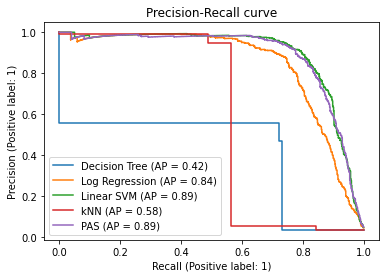

In [22]:
# Plotting the PR curves for every model
model_dt.fit(X_train, y_train), model_logreg.fit(X_train, y_train), model_linsvc.fit(X_train, y_train), model_knn.fit(X_train, y_train), model_paa.fit(X_train, y_train)

plot_precision_recall_curve(model_dt, X_test, y_test, ax = plt.gca(),name = "Decision Tree")
plot_precision_recall_curve(model_logreg, X_test, y_test, ax = plt.gca(),name = "Log Regression")
plot_precision_recall_curve(model_linsvc, X_test, y_test, ax = plt.gca(),name = "Linear SVM")
plot_precision_recall_curve(model_knn, X_test, y_test, ax = plt.gca(),name = "kNN")
plot_precision_recall_curve(model_paa, X_test, y_test, ax = plt.gca(),name = "PAS")
plt.savefig('PR-Curve.png', dpi=600) 
plt.title('Precision-Recall curve')

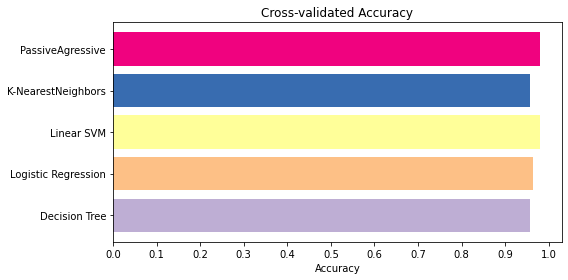

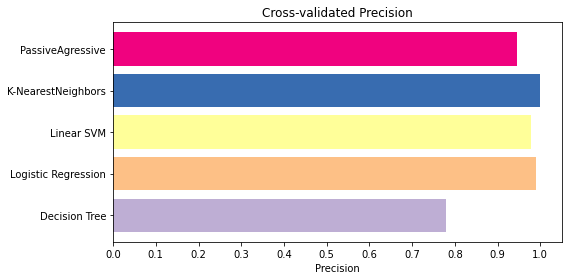

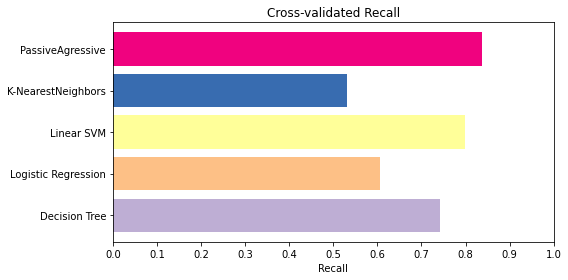

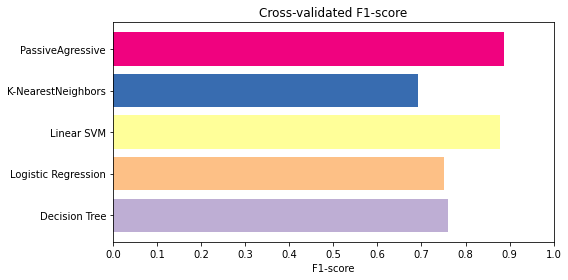

In [21]:
# Visualizing the performance with different metrics using a bar plot
plt.figure(figsize=(8,4), tight_layout=True)
colors = sns.color_palette('Accent')

plt.barh(list(acc.keys()), list(acc.values()), color=colors[1:16])
plt.title("Cross-validated Accuracy")
plt.xlabel('Accuracy')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('CV-Accuracy.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(prec.keys()), list(prec.values()), color=colors[1:16])
plt.title("Cross-validated Precision")
plt.xlabel('Precision')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('CV-Precision.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(rec.keys()), list(rec.values()), color=colors[1:16])
plt.title("Cross-validated Recall")
plt.xlabel('Recall')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('CV-Recall.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(f1.keys()), list(f1.values()), color=colors[1:16])
plt.title("Cross-validated F1-score")
plt.xlabel('F1-score')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('CV-F1.png', dpi=600) 
plt.show()

RandomSearch, used to get a general sense of where the hypertuning for a certain model is directed, testing different combinations of parameters at random while looking for the one that gets the highest score, in this case, recall

In [21]:
# Stating the parameter grids that will be tested with the randomsearch
dt_param_grid = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2,4,6,8,10,12], 
    'max_leaf_nodes': [2,4,6,8,10,20,30,40,50,70,90,100], 
    'min_samples_leaf': [2,3,4,5,7,9,11,16,18], 
    }

logreg_param_grid = {             
    #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
    'C': [.1, 1, 5, 10, 30, 50, 70, 90, 110, 130, 150],
    'fit_intercept': [True, False], #default: True
    'penalty': ['l1','l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear'], #default: lbfgs
    }

logreg_param_grid2 = {             
    #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
    'fit_intercept': [True, False], #default: True
    'C': [1, 10, 30, 50, 70, 90, 110, 130, 150],
    'penalty': ['l2'],
    'class_weight': ['balanced', None],
    'dual': [True, False],
    'solver': ['liblinear'], #default: lbfgs
    }

linsvc_param_grid = {
    'C': [.001, .01, .05, .1, .2, .6, 1, 1.4, 1.8, 2],
    'class_weight': ['balanced', None], 
    'dual': [True], 
    'fit_intercept': [False, True], 
    'loss': ['hinge', 'squared_hinge'], 
}

knn_param_grid = {
    #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21,23,25,27,30], #default: 5
    'weights': ['uniform', 'distance'], #default = ‘uniform’
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

paa_param_grid = {
    'C': [.001, .01, .05, .1, .2, .6, 1, 1.4, 1.8, 2],
    'shuffle': [False, True],
    'fit_intercept': [False, True], 
    'class_weight': ['balanced', None],
    'loss': ['hinge', 'squared_hinge']
}

models_params = {
    'Decision Tree': [model_dt, dt_param_grid],
    'Logistic Regression': [model_logreg, logreg_param_grid],
    'Logistic Regression2': [model_logreg, logreg_param_grid2],
    'Linear SVC': [model_linsvc, linsvc_param_grid],
    'K-NearestNeighbors': [model_knn, knn_param_grid],
    'Passive Agressive': [model_paa, paa_param_grid]
    }

In [22]:
best_parameters = {}
best_score = {}

for name, [model, param] in models_params.items():
    print(f'{name} Random search starting')
    search = RandomizedSearchCV(estimator = model, 
                                param_distributions = param, 
                                n_iter = 10, 
                                cv = kf, 
                                verbose=0, 
                                scoring='recall',
                                random_state=42, 
                                n_jobs = -1).fit(X_train, y_train)
    best_parameters[name] = search.best_estimator_
    best_score[name] = search.best_score_
    print('Best score (recall): ', best_score[name])
    print('Best parameters: ', best_parameters[name], '\n')

Decision Tree Random search starting
Best score (recall):  0.479579731937786
Best parameters:  DecisionTreeClassifier(criterion='entropy', max_depth=12, max_leaf_nodes=100,
                       min_samples_leaf=16) 

Logistic Regression Random search starting
Best score (recall):  0.8886817919776749
Best parameters:  LogisticRegression(C=1, class_weight='balanced', fit_intercept=False,
                   penalty='l1', solver='liblinear') 

Logistic Regression2 Random search starting
Best score (recall):  0.8720562066033983
Best parameters:  LogisticRegression(C=1, class_weight='balanced', dual=True, solver='liblinear') 

Linear SVC Random search starting
Best score (recall):  0.9008186264264906
Best parameters:  LinearSVC(C=0.001, class_weight='balanced', fit_intercept=False, loss='hinge') 

K-NearestNeighbors Random search starting


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score (recall):  0.5207748968267435
Best parameters:  KNeighborsClassifier() 

Passive Agressive Random search starting
Best score (recall):  0.8220959163086858
Best parameters:  PassiveAggressiveClassifier(C=1, class_weight='balanced') 



GridSearch, after having a general idea of what parameters work best with each model and discarding the models which seemingly have no possibility of achieving good results, a gridsearch can now be performed to further improve the model performance, gridsearch, differently from randomsearch, tests every possible combination of parameters

In [42]:
logreg_param_grid = {             
    #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
    'fit_intercept': [True, False], #default: True
    'C': [70, 80, 90, 100, 110, 120],
    'penalty': ['l2'],
    'class_weight': ['balanced', None],
    'solver': ['liblinear'], #default: lbfgs
    }

linsvc_param_grid = {
    'C': [.05, .10, .15, .20], 
    'class_weight': ['balanced', None], 
    'dual': [True], 
    'fit_intercept': [False, True], 
    'loss': ['hinge', 'squared_hinge'], 
}

paa_param_grid = {
    'C': [.05, .10, .15, .20], 
    'shuffle': [False, True],
    'fit_intercept': [False, True], 
    'class_weight': ['balanced', None],
}

models_params = {
    'Logistic Regression': [model_logreg, logreg_param_grid],
    'Linear SVC': [model_linsvc, linsvc_param_grid],
    'Passive Agressive': [model_paa, paa_param_grid]
    }

In [43]:
best_parameters = {}
best_score = {}

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

for name, [model, param] in models_params.items():
    print(f'{name} Grid search starting')
    search = GridSearchCV(model, 
                          param, 
                          cv=kf, 
                          # scoring='recall',
                          scoring=scoring,
                          refit='recall', 
                          n_jobs=-1, 
                          verbose=0).fit(X_train, y_train)
    best_parameters[name] = search.best_estimator_
    best_score[name] = search.best_score_
    print('Best accuracy: ', round(search.cv_results_['mean_test_accuracy'].mean(),4))
    print('Best precision: ', round(search.cv_results_['mean_test_precision'].mean(),4))
    print('Best recall: ', round(search.cv_results_['mean_test_recall'].mean(),4))
    print('Best parameters: ', best_parameters[name], '\n')

Logistic Regression Grid search starting
Best accuracy:  0.9905
Best precision:  0.9091
Best recall:  0.8117
Best parameters:  LogisticRegression(C=70, class_weight='balanced', fit_intercept=False,
                   solver='liblinear') 

Linear SVC Grid search starting
Best accuracy:  0.9831
Best precision:  0.8504
Best recall:  0.7072
Best parameters:  LinearSVC(C=0.1, class_weight='balanced', fit_intercept=False, loss='hinge') 

Passive Agressive Grid search starting
Best accuracy:  0.9905
Best precision:  0.9133
Best recall:  0.8065
Best parameters:  PassiveAggressiveClassifier(C=0.1, class_weight='balanced', fit_intercept=False) 



Then the same cross-validation approach as before is performed, but this time with the parameters that make the model perform the best. In addition, PR curve and bar plots are also produced.

In [38]:
model_logreg_tuned = LogisticRegression(C=110, class_weight='balanced', fit_intercept=False, penalty='l2', dual=True, solver='liblinear') 
model_linsvc_tuned = LinearSVC(C=0.2, class_weight='balanced', fit_intercept=False, loss='hinge', random_state=0) 
model_paa_tuned = PassiveAggressiveClassifier(C=0.25, class_weight='balanced', fit_intercept=False, random_state=0)

models = {
    'Logistic Regression': model_logreg_tuned,
    'Linear SVM': model_linsvc_tuned,
    'Passive Agressive': model_paa_tuned
    }

kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [39]:
acc = {}
prec = {}
rec = {}
f1 = {}

for name, model in models.items():
    print(f"Tuned {name} results:")
    score = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1, verbose=0)
    print("Accuracy: ", round(score['test_accuracy'].mean(),4))
    print("Precision: ", round(score['test_precision'].mean(),4))
    print("Recall: ", round(score['test_recall'].mean(),4))
    print("F1_score: ", round(score['test_f1_score'].mean(),4), '\n')

    acc[name] = score['test_accuracy'].mean()
    prec[name] = score['test_precision'].mean()
    rec[name] = score['test_recall'].mean()
    f1[name] = score['test_f1_score'].mean()

Tuned Logistic Regression results:
Accuracy:  0.99
Precision:  0.8579
Recall:  0.8537
F1_score:  0.8553 

Tuned Linear SVM results:
Accuracy:  0.9846
Precision:  0.7294
Recall:  0.887
F1_score:  0.8001 

Tuned Passive Agressive results:
Accuracy:  0.9896
Precision:  0.8635
Recall:  0.8325
F1_score:  0.8474 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use o

Text(0.5, 1.0, 'Precision-Recall curve')

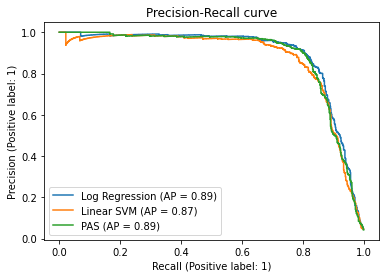

In [26]:
model_logreg.fit(X_train, y_train), model_linsvc.fit(X_train, y_train), model_paa.fit(X_train, y_train)

plot_precision_recall_curve(model_logreg, X_test, y_test, ax = plt.gca(),name = "Log Regression")
plot_precision_recall_curve(model_linsvc, X_test, y_test, ax = plt.gca(),name = "Linear SVM")
plot_precision_recall_curve(model_paa, X_test, y_test, ax = plt.gca(),name = "PAS")
plt.savefig('PR-TunedCurve.png', dpi=600) 
plt.title('Precision-Recall curve')

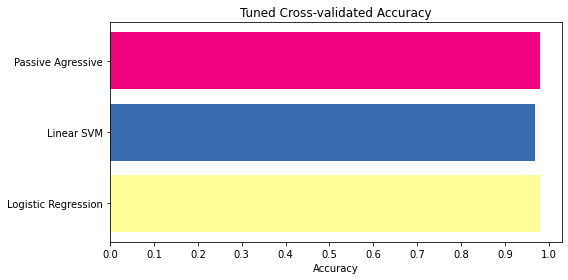

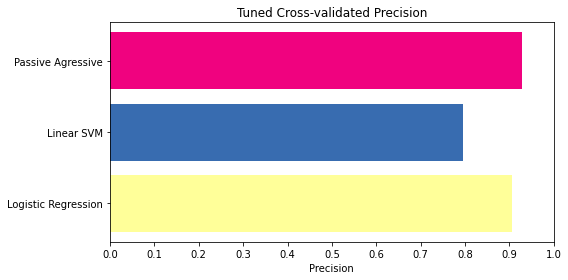

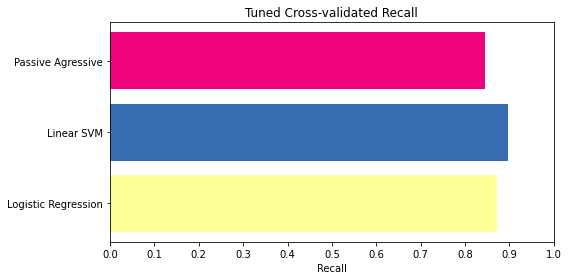

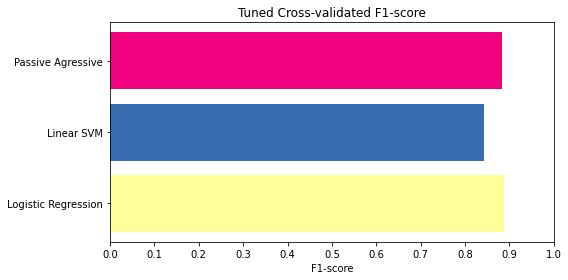

In [27]:
plt.figure(figsize=(8,4), tight_layout=True)
colors = sns.color_palette('Accent')

plt.barh(list(acc.keys()), list(acc.values()), color=colors[3:16])
plt.title("Tuned Cross-validated Accuracy")
plt.xlabel('Accuracy')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('TunedCV-Accuracy.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(prec.keys()), list(prec.values()), color=colors[3:16])
plt.title("Tuned Cross-validated Precision")
plt.xlabel('Precision')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('TunedCV-Precision.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(rec.keys()), list(rec.values()), color=colors[3:16])
plt.title("Tuned Cross-validated Recall")
plt.xlabel('Recall')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('TunedCV-Recall.png', dpi=600) 
plt.show()

plt.figure(figsize=(8,4), tight_layout=True)
plt.barh(list(f1.keys()), list(f1.values()), color=colors[3:16])
plt.title("Tuned Cross-validated F1-score")
plt.xlabel('F1-score')
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('TunedCV-F1.png', dpi=600) 
plt.show()

Testing the model on the test set, to see how it performs on unseen data.

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression model results:
              precision    recall  f1-score   support

           0     0.9941    0.9955    0.9948     19307
           1     0.8701    0.8352    0.8523       698

    accuracy                         0.9899     20005
   macro avg     0.9321    0.9154    0.9236     20005
weighted avg     0.9897    0.9899    0.9898     20005



Passive Aggressive model results:
              precision    recall  f1-score   support

           0     0.9931    0.9963    0.9947     19307
           1     0.8868    0.8080    0.8456       698

    accuracy                         0.9897     20005
   macro avg     0.9399    0.9021    0.9201     20005
weighted avg     0.9894    0.9897    0.9895     20005





/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Linear SVM model results:
              precision    recall  f1-score   support

           0     0.9957    0.9886    0.9921     19307
           1     0.7356    0.8811    0.8018       698

    accuracy                         0.9848     20005
   macro avg     0.8657    0.9348    0.8970     20005
weighted avg     0.9866    0.9848    0.9855     20005





/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


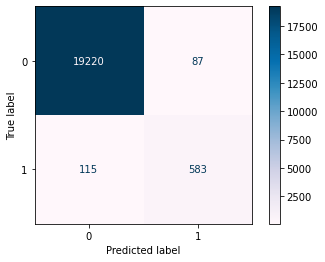

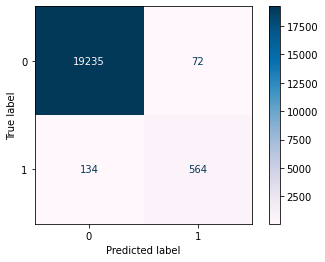

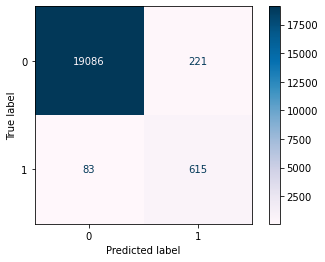

In [44]:
clf = LogisticRegression(C=110, class_weight='balanced', fit_intercept=False, penalty='l2', dual=True, solver='liblinear') 
clf2 = PassiveAggressiveClassifier(C=0.25, class_weight='balanced', fit_intercept=False, random_state=0)
clf3 = LinearSVC(C=0.2, class_weight='balanced', fit_intercept=False, loss='hinge', random_state=0) 

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Logistic Regression model results:')
print(classification_report(y_test, y_pred, digits = 4))
plot_confusion_matrix(clf, X_test, y_test, cmap='PuBu')
print('\n')

clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
print('Passive Aggressive model results:')
print(classification_report(y_test, y_pred2, digits = 4))
plot_confusion_matrix(clf2, X_test, y_test, cmap='PuBu')
print('\n')

clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
print('Linear SVM model results:')
plot_confusion_matrix(clf3, X_test, y_test, cmap='PuBu')
print(classification_report(y_test, y_pred3, digits = 4))
print('\n')

As a final approach to control the precision/recall threshold, an analysis on the effects of thresholds going from .1 to .9 is done, to see how this metrics are affected

In [39]:
def custom_predict(X_train, threshold):
    probs = clf.predict_proba(X_test) 
    return (probs[:, 1] > threshold).astype(int)
    
clf = LogisticRegression(C=110, class_weight='balanced', fit_intercept=False, penalty='l2', dual=True, solver='liblinear') 
clf.fit(X_train, y_train)

rec = []
prec = []

for i in range(1,10):
  y_pred = custom_predict(X_test, threshold=i/10) 
  print('Threshold:', i/10)
  print('Recall =', recall_score(y_test, y_pred, average='macro'))
  print('Precision =', precision_score(y_test, y_pred, average='macro'), '\n')

  rec.append(recall_score(y_test, y_pred, average='macro'))
  prec.append(precision_score(y_test, y_pred, average='macro'))

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Threshold: 0.1
Recall = 0.9412842306849232
Precision = 0.8001469979609553 

Threshold: 0.2
Recall = 0.9351230747106436
Precision = 0.8589377777190143 

Threshold: 0.3
Recall = 0.9274940810843582
Precision = 0.8865621592605639 

Threshold: 0.4
Recall = 0.9222642647981796
Precision = 0.9103774571392019 

Threshold: 0.5
Recall = 0.9153687076691605
Precision = 0.9321007453037373 

Threshold: 0.6
Recall = 0.9094914578096666
Precision = 0.945937792982781 

Threshold: 0.7
Recall = 0.9041751562708005
Precision = 0.9567587852258099 

Threshold: 0.8
Recall = 0.8967357549401964
Precision = 0.9690606092136365 

Threshold: 0.9
Recall = 0.8797768539492261
Precision = 0.9749490388418403 



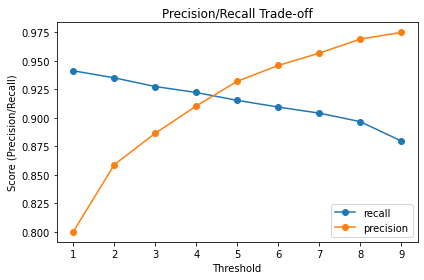

In [62]:
plt.figure(tight_layout=True)
plt.plot(range(1,len(rec)+1), rec, marker='o', label='recall',)
plt.plot(range(1,len(prec)+1), prec, marker='o', label='precision',)
plt.title("Precision/Recall Trade-off")
plt.xticks(np.arange(1, 10, 1))
plt.ylabel('Score (Precision/Recall)')
plt.xlabel('Threshold')
plt.legend(loc='lower right')
plt.savefig('PrecRec-Tradeoff.png', dpi=600) 
plt.show()

BERT

In [4]:
!pip install transformers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertModel, BertTokenizer, TFBertModel, AutoTokenizer
from mlxtend.plotting import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 30.9 MB/s 
     |████████████████████████████████| 7.6 MB 60.6 MB/s 
     |████████████████████████████████| 182 kB 81.0 MB/s 


In [5]:
# Initializing bert model and tokenizer
# bert_model = TFBertModel.from_pretrained('prajjwal1/bert-tin', from_pt=True)
# bert_tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

bert_model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

# Function to create model
maxlen=100
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [6]:
X = data['content']
y = data['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=0)

# Applying tokenizing to train and test news
X_train = tokenize(X_train)
X_test = tokenize(X_test)

X_train

{'input_ids': <tf.Tensor: shape=(46676, 100), dtype=int32, numpy=
array([[  101,  2065,  1996, ...,     0,     0,     0],
       [  101,  3449,  5495, ...,     0,     0,     0],
       [  101,  1996,  2231, ...,     0,     0,     0],
       ...,
       [  101, 26839, 18720, ...,     0,     0,     0],
       [  101,  7758,  4067, ...,     0,     0,     0],
       [  101,  9871,  8390, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(46676, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [7]:
# Creating BERT model, based on pre-trained model
model=create_model()

# Specifiying which optimizer to use for the NN
optimizer = Adam(learning_rate=1e-05, 
                 epsilon=1e-08, 
                 decay=0.01,
                 clipnorm=1.0)

# Compiling modle with chosen optimizer and metrics
model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = 'accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [8]:
# Callback function
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            mode='max', 
                                            verbose=1, 
                                            patience=50,
                                            baseline=0.4,
                                            min_delta=0.0001,
                                            restore_best_weights=False)

In [9]:
# Training NN
history = model.fit(x = {'input_1':X_train['input_ids'],
                         'input_2':X_train['attention_mask']}, 
                         y = y_train, 
                         epochs=8, 
                         validation_split = 0.3, 
                         batch_size = 24, 
                         callbacks=[callback])

Epoch 1/8
1362/1362 [==============================] - 786s 561ms/step - loss: 0.1223 - accuracy: 0.9642 - val_loss: 0.0861 - val_accuracy: 0.9650
Epoch 2/8
1362/1362 [==============================] - 771s 566ms/step - loss: 0.0904 - accuracy: 0.9665 - val_loss: 0.0734 - val_accuracy: 0.9689
Epoch 3/8
1362/1362 [==============================] - 772s 567ms/step - loss: 0.0804 - accuracy: 0.9687 - val_loss: 0.0694 - val_accuracy: 0.9739
Epoch 4/8
1362/1362 [==============================] - 773s 567ms/step - loss: 0.0753 - accuracy: 0.9705 - val_loss: 0.0636 - val_accuracy: 0.9773
Epoch 5/8
1362/1362 [==============================] - 773s 568ms/step - loss: 0.0714 - accuracy: 0.9715 - val_loss: 0.0611 - val_accuracy: 0.9785
Epoch 6/8
1362/1362 [==============================] - 776s 570ms/step - loss: 0.0694 - accuracy: 0.9730 - val_loss: 0.0593 - val_accuracy: 0.9794
Epoch 7/8
1362/1362 [==============================] - 775s 569ms/step - loss: 0.0654 - accuracy: 0.9744 - val_loss: 0

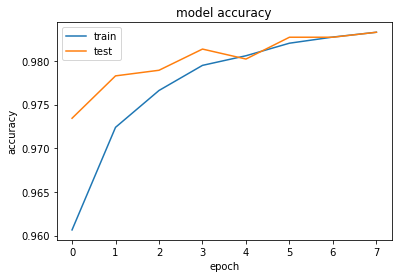

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('BERT-Accuracy.png', dpi=600) 
plt.show()

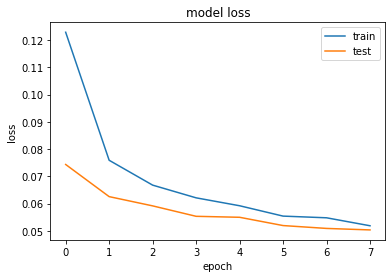

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('BERT-Loss.png', dpi=600) 
plt.show()

In [ ]:
y_pred = np.where(model.predict({ 'input_1' : X_test['input_ids'], 
                                 'input_2' : X_test['attention_mask']}) >0.5,1,0)

626/626 [==============================] - 137s 214ms/step


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19307
           1       0.76      0.71      0.73       698

    accuracy                           0.98     20005
   macro avg       0.88      0.85      0.86     20005
weighted avg       0.98      0.98      0.98     20005



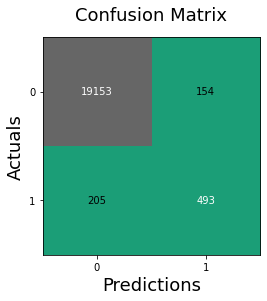

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, cmap='Dark2')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# tf.keras.backend.clear_session()